# Assay and run directory

In [113]:
assay_name = "/common/workdir/diverse_molecule_generation/datasets/egfr_filtered.csv"
rundir = "/common/workdir/diverse_molecule_generation/results/egfr_filtered/lstm_hc/egfr_filtered/"
pca_components = 50
kmeans = True 

results/test/lstm_hc/CHEMBL3888429_cleaned/ecfp4_range_physchem_maxsim_ecfp6/2022-03-17_13:33:05

# Analysis

In [114]:
import os
import numpy as np
import json
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA
from utils import data_split, ClusterFps, ecfp4, find_cluster, max_tanimoto_similarity, indexes_identical_fps, average_tanimoto_similarity, tanimoto_similarities, calculateScore, Descriptors, quantitative_analysis

import matplotlib.pyplot as plt
import math
import scipy
import pandas as pd
import seaborn as sns 
import matplotlib
from sklearn.cluster import KMeans

from rdkit.Chem.rdMolDescriptors import CalcTPSA
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem.Crippen import MolLogP, MolMR


font = {'family' : 'normal',
        'size'   : 35}

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': 35,
    'text.usetex': False,
    'pgf.rcfonts': False,
})


matplotlib.rcParams['axes.unicode_minus'] = False
%matplotlib inline 

In [115]:
scores_test, smiles_test, activities_test, clf = data_split(assay_name)

In [116]:
os.listdir(rundir)

['ecfp4_range_physchem_range_ecfp4_counts_beta_ 0_threshold_0.7',
 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 1_threshold_0.7',
 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 10_threshold_0.7',
 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 100_threshold_0.7',
 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 1000_threshold_0.7']

In [117]:
runs = []
smiles_list = []
scores_list = []
scores_trajectories = []


for directory in os.listdir(rundir):
    smiles = []
    scores = []
    trajectories = []
    for result_dir in os.listdir(os.path.join(rundir, directory)):
        try:
            with open(os.path.join(rundir, directory, result_dir, 'results.json'), 'r') as f:
                results = json.load(f)
                smiles.extend([row['smiles'] for row in results['statistics']][-1])
                scores.extend([row['preds']['scores'] for row in results['statistics']][-1])
                #trajectories.extend([np.array(row['preds']['Split1']) for row in results['statistics']])
                average_trajectories = np.array([np.mean(row['preds']['scores']) for row in results['statistics']])
        except:
            pass
    if len(smiles)>0:
        runs.append(directory)
        scores_trajectories.append(average_trajectories)
        smiles_list.append(smiles)
        scores_list.append(scores)


In [118]:
actives = []
inactives = []
smiles_actives = []
smiles_inactives = []

for i, s in enumerate(smiles_test):
    mol = Chem.MolFromSmiles(s)
    if float(activities_test[i])==1:
        actives.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
        smiles_actives.append(s)
    else:
        inactives.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
        smiles_inactives.append(s)


In [119]:
X = np.array(actives + inactives)
#clustering = DBSCAN(eps=0.25, min_samples=1, metric='jaccard', p=1).fit(X)
clustering = KMeans(n_clusters=5, random_state=0).fit(X)

kmeans_clusters = clustering.labels_

In [120]:
training_set_clusters = ClusterFps(actives + inactives, cutoff=0.5)

In [121]:
centroids = [cluster[0] for cluster in training_set_clusters]
fp_list = actives + inactives
centroids_fp = [fp_list[centroid] for centroid in centroids]

In [122]:
fps_active_as_array = []
fps_active_as_bitv = []
fps_inactive_as_array = []
fps_inactive_as_bitv = []
fps_generated_as_array = []
fps_generated_as_bitv = []

for s in smiles_actives:
    mol = Chem.MolFromSmiles(s)
    fps_active_as_array.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)))
    fps_active_as_bitv.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    
for s in smiles_inactives:
    mol = Chem.MolFromSmiles(s)
    fps_inactive_as_array.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)))
    fps_inactive_as_bitv.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    
for i, run in enumerate(runs):
    smiles_generated = smiles_list[i]
    curr_fps_generated_as_array = []
    curr_fps_generated_as_bv = []
    for s in smiles_generated:
        mol = Chem.MolFromSmiles(s)
        curr_fps_generated_as_array.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)))
        curr_fps_generated_as_bv.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    fps_generated_as_array.append(curr_fps_generated_as_array)
    fps_generated_as_bitv.append(curr_fps_generated_as_bv)
    

In [123]:
pca = PCA(n_components=2).fit(np.concatenate((fps_inactive_as_array,fps_inactive_as_array)))
pca_active = pca.transform(fps_active_as_array)
pca_inactive = pca.transform(fps_inactive_as_array)

pca_generated = []

for i, run in enumerate(runs):
    curr_fps_generated = fps_generated_as_array[i]
    pca_generated.append(pca.transform(curr_fps_generated))

In [124]:
xmin_ymin = np.amin(np.vstack([np.amin(p, axis=0) for p in pca_generated]), axis=0).tolist()

In [125]:
xmax_ymax = np.amax(np.vstack([np.amax(p, axis=0) for p in pca_generated]), axis=0).tolist()

In [126]:
x_lims = [xmin_ymin[0]] + [xmax_ymax[0]]
y_lims = [xmin_ymin[1]] + [xmax_ymax[1]]

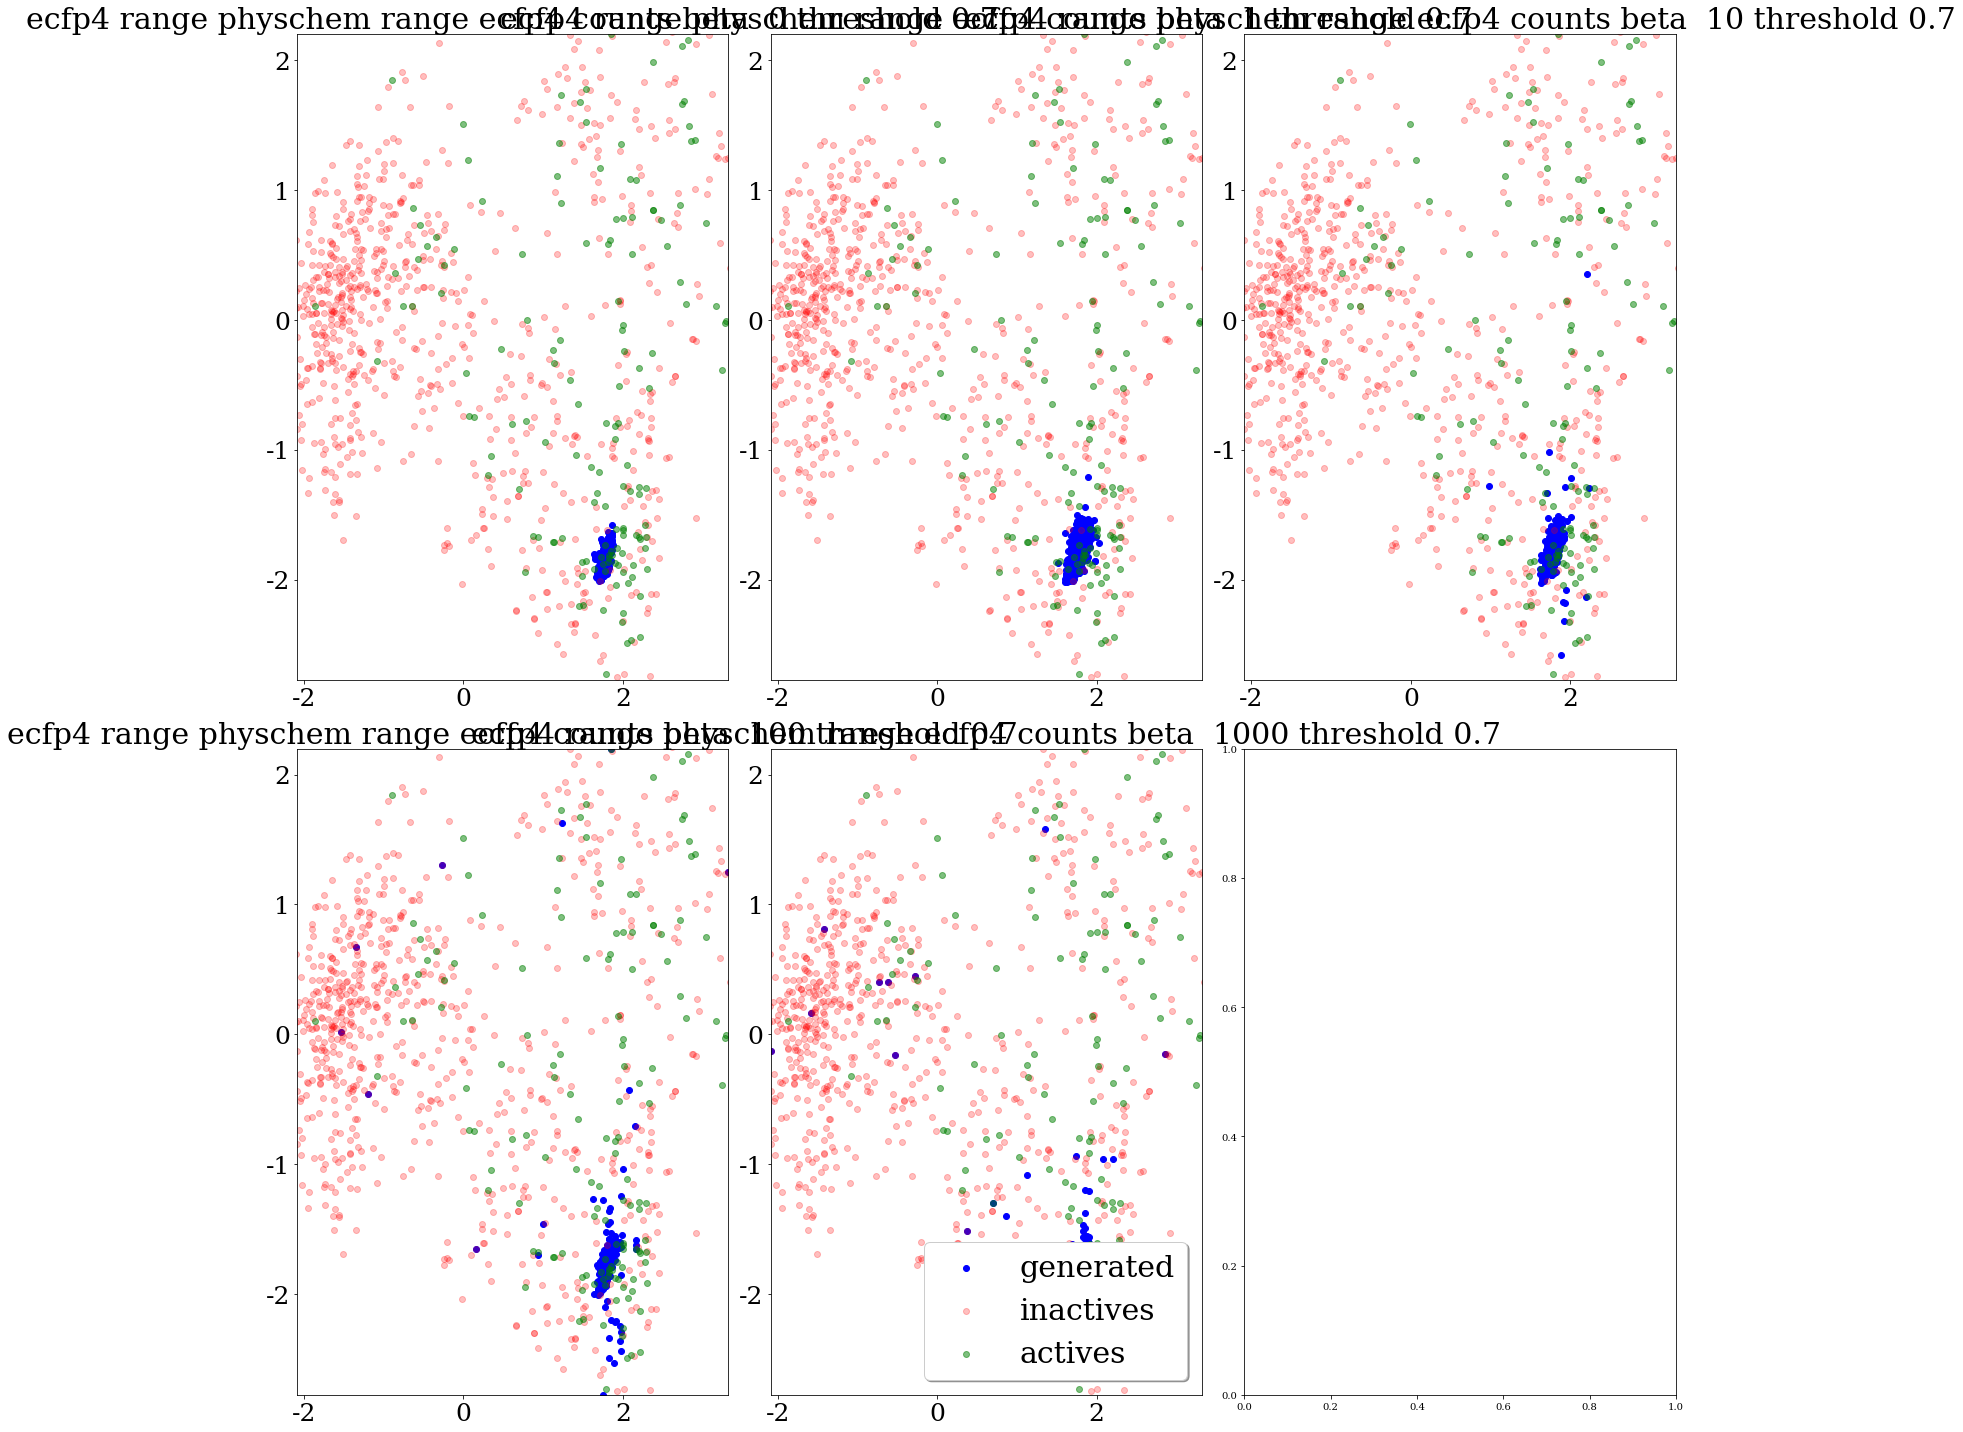

In [127]:
runs_to_display = runs
#runs_to_display = runs 
fig, axs = plt.subplots(figsize = (20, 20), nrows=max(1, math.ceil(len(runs_to_display)/3)) , ncols=3)
fig.tight_layout(pad=1.5)

for i, run in enumerate(runs_to_display):
    index = runs.index(run)
    pca_gen = pca_generated[index]
    ax = axs.flatten()[i]
    ax.set_title(run.replace('_', ' '), fontsize=30)
    ax.set_ylim(y_lims)
    ax.set_xlim(x_lims)
    ax.scatter(pca_gen[:, 0], pca_gen[:, 1], c='b', label = 'generated', alpha=1)
    ax.scatter(pca_inactive[:, 0], pca_inactive[:, 1], c='r', label = 'inactives', alpha=0.25)
    ax.scatter(pca_active[:, 0], pca_active[:, 1], c='g', label = 'actives', alpha=0.5)
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.tick_params(axis='both', which='minor', labelsize=25)
    if i==len(runs_to_display)-1: 
        ax.legend(loc='lower right',
              ncol=1, fancybox=True, shadow=True, fontsize=30)
    
plt.tight_layout()
#plt.savefig('images/JAK2/PCA.png', dpi=300)   

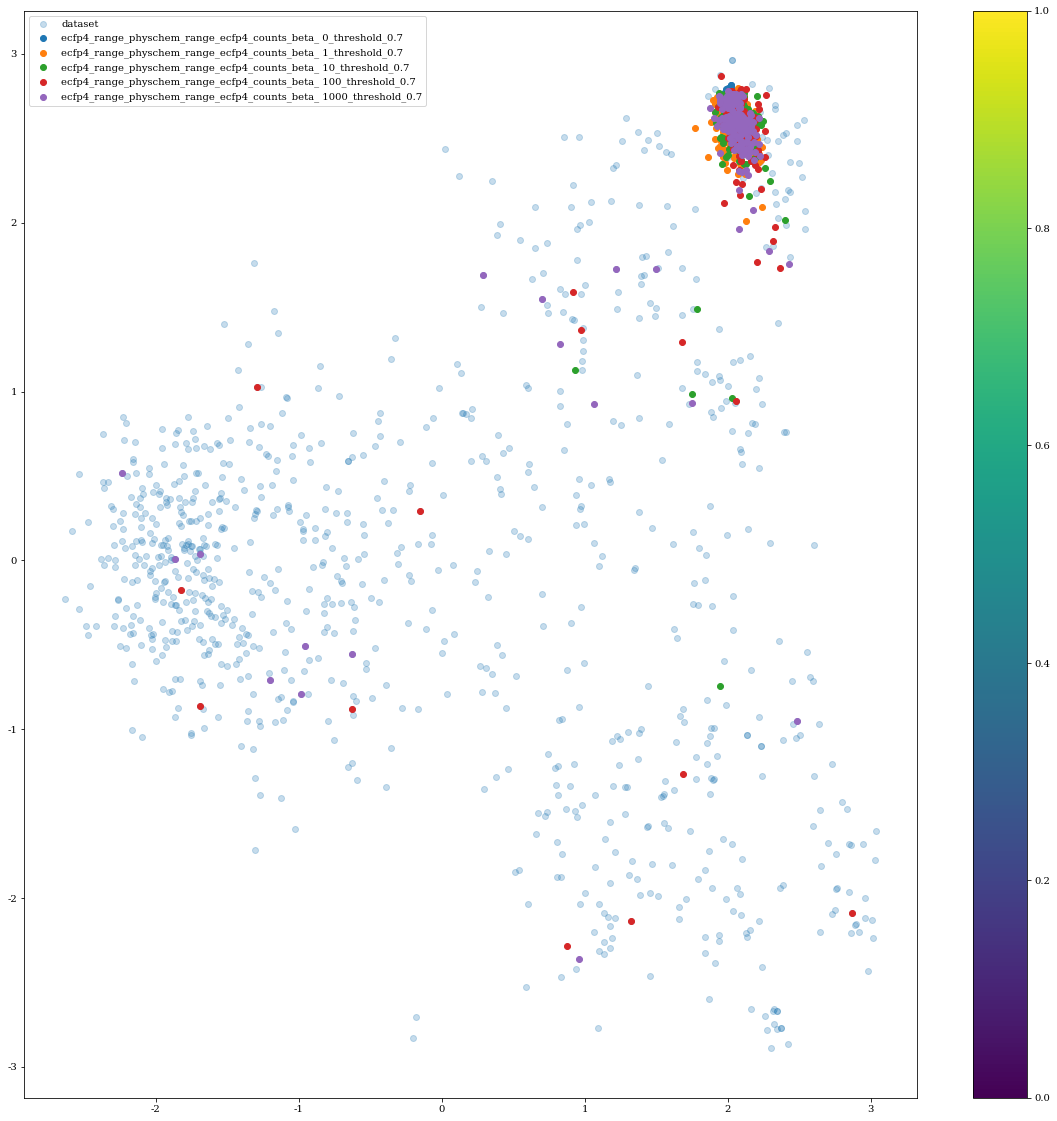

In [128]:
fps = []
for s in smiles_test:
    mol = Chem.MolFromSmiles(s)
    fps.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)))
    
plt.figure(figsize=(20, 20))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(fps)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

validity = []

    
for s in smiles_test:
    mol = Chem.MolFromSmiles(s)
    fp = ecfp4([s])[0].reshape(1, -1)
    prediction = clf.predict_proba(fp)[0, 1]
    validity.append(prediction) 

plt.scatter(X_pca[:, 0], X_pca[:, 1], label='dataset', alpha=0.25)

for i, run in enumerate(runs):
    X_generated = []
    for s in smiles_list[i]:
        mol = Chem.MolFromSmiles(s)
        X_generated.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)))
    X_transformed = pca.transform(X_generated)
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=colors[i], label=run)

plt.colorbar()

plt.legend()

In [129]:
pca_generated = []
entropies = []
clusters = []
    
pca = PCA(n_components=2).fit(np.concatenate((fps_active_as_array,fps_inactive_as_array)))
pca_active = pca.transform(fps_active_as_array)
pca_inactive = pca.transform(fps_inactive_as_array)
predicted_actives = np.where(clf.predict_proba(ecfp4(smiles_actives))[:, 1]>0.5)[0]

for i, run in enumerate(runs):
    curr_fps_generated = fps_generated_as_array[i]
    curr_fps_generated_bitv = fps_generated_as_bitv[i]    
    pca_generated.append(pca.transform(curr_fps_generated))
    if kmeans:
        curr_clusters = clustering.predict(curr_fps_generated)  
    else:
        curr_clusters = [find_cluster(fp, centroids_fp) for fp in curr_fps_generated_bitv]
    probs = []
    for i in range(len(np.unique(centroids))):
        probs.append(len(np.where(np.array(curr_clusters)==i)[0])/len(curr_clusters))
    entropy = scipy.stats.entropy(probs)/ np.log(len(curr_clusters))
    clusters.append(curr_clusters)
    entropies.append(entropy)

In [130]:
xmin_ymin = np.amin(np.vstack([np.amin(p, axis=0) for p in pca_generated]), axis=0).tolist()
xmax_ymax = np.amax(np.vstack([np.amax(p, axis=0) for p in pca_generated]), axis=0).tolist()
x_lims = [xmin_ymin[0]] + [xmax_ymax[0]]
y_lims = [xmin_ymin[1]] + [xmax_ymax[1]]

Text(0.5, 1.05, 'PCA projections of generated molecules in the training set actives/inactives space\nHighlighting predicted actives')

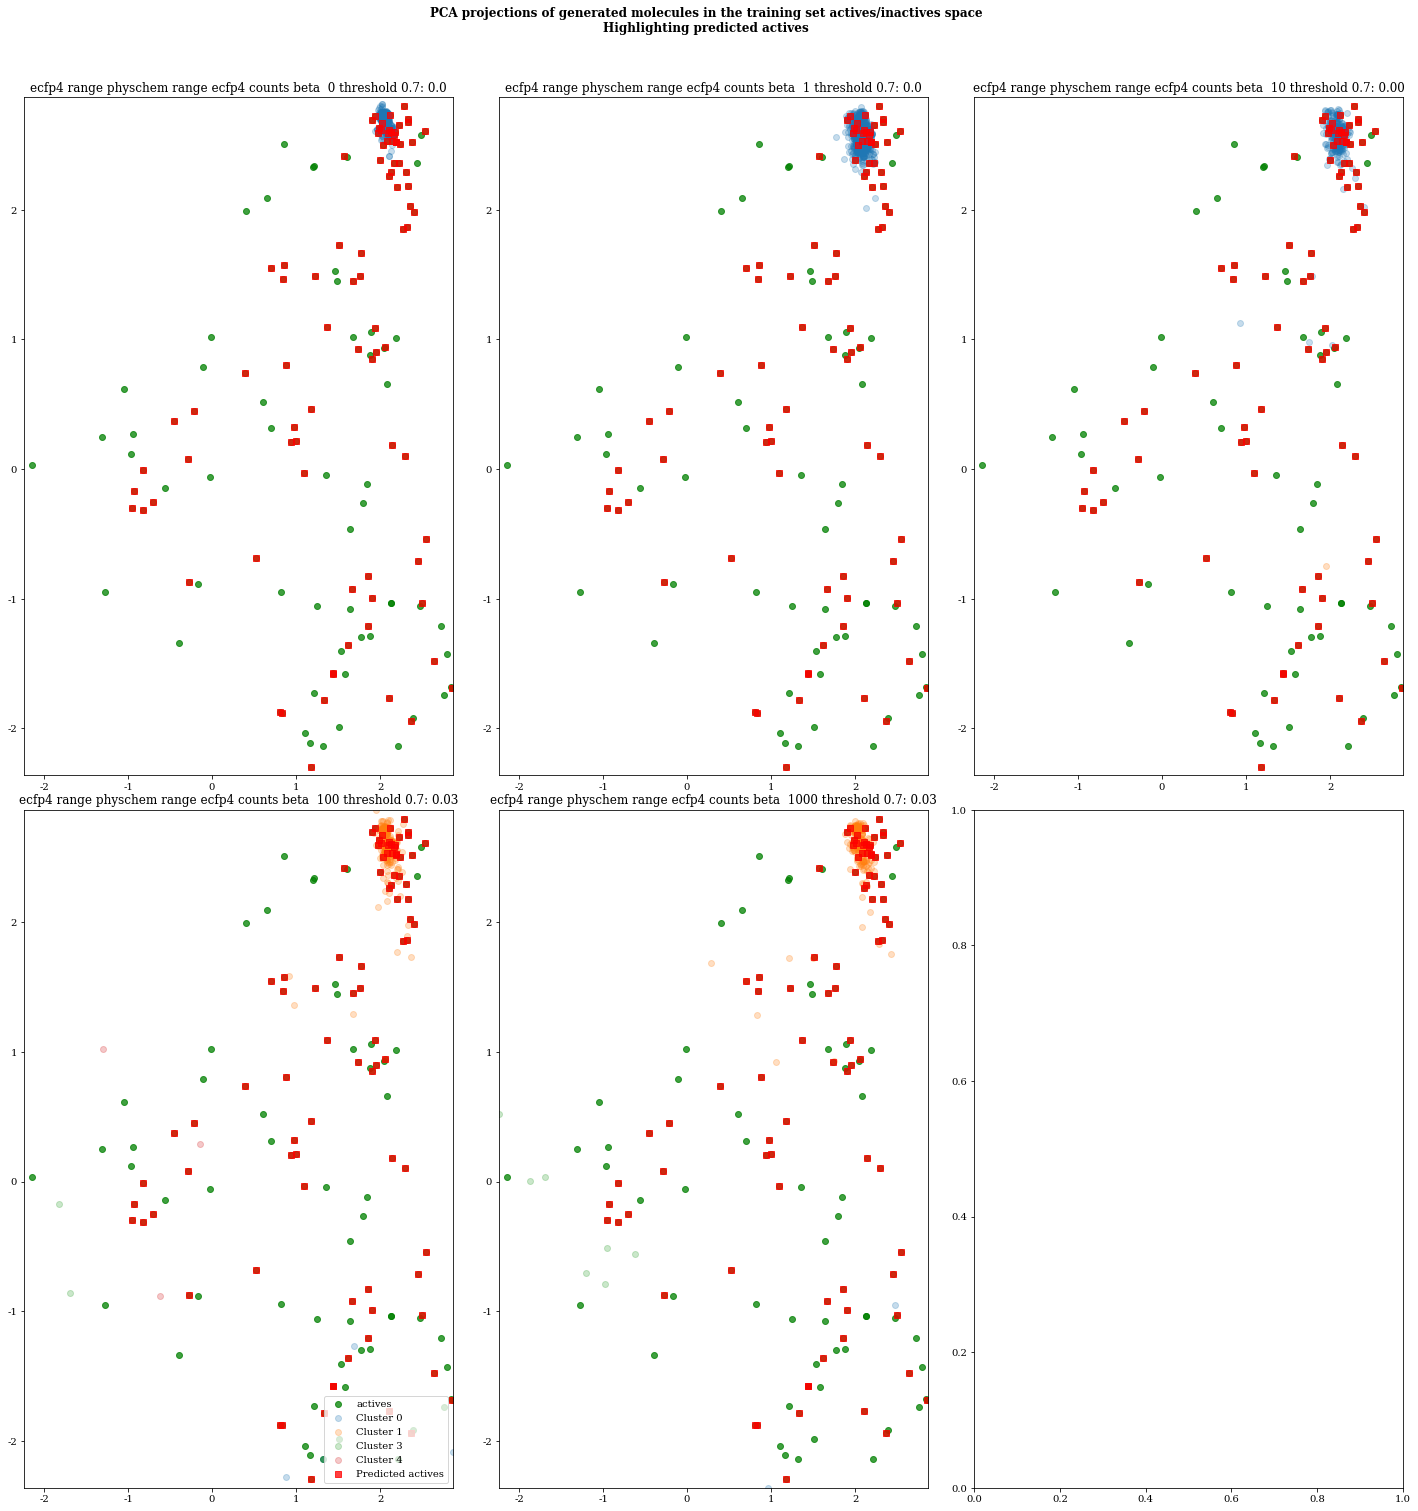

In [131]:
fig, axs = plt.subplots(figsize = (20, 20), nrows=max(1, math.ceil(len(runs)/3)) , ncols=3)
fig.tight_layout(pad=1.5)
no_legend = 0

for i, run in enumerate(runs):
    curr_clusters = clusters[i]
    entropy = entropies[i]
    pca_gen = pca_generated[i]
    ax = axs.flatten()[i]
    ax.set_title(run.replace('_', ' ') + ': ' + str(entropy)[:4])
    ax.set_ylim(y_lims)
    ax.set_xlim(x_lims)
    ax.scatter(pca_active[:, 0], pca_active[:, 1], c='g', label = 'actives', alpha=0.75)    
    for c in np.unique(curr_clusters):
        ax.scatter(pca_gen[:, 0][np.where(curr_clusters==c)], pca_gen[:, 1][np.where(curr_clusters==c)], label= 'Cluster ' + str(c), alpha=0.25)    

    ax.scatter(pca_active[predicted_actives, 0], pca_active[predicted_actives, 1], c='r', label = 'Predicted actives', alpha=0.75, marker='s')
    #ax.scatter(pca_inactive[:, 0], pca_inactive[:, 1], c='r', label = 'inactives', alpha=0.25)
    if len(np.unique(curr_clusters)) == np.amax([len(set(c)) for c in clusters]) and  no_legend == 0 :
        ax.legend(loc=4)
        no_legend = 1
fig.suptitle('PCA projections of generated molecules in the training set actives/inactives space\nHighlighting predicted actives',fontweight ="bold", y=1.05)    

<Figure size 1800x1800 with 0 Axes>

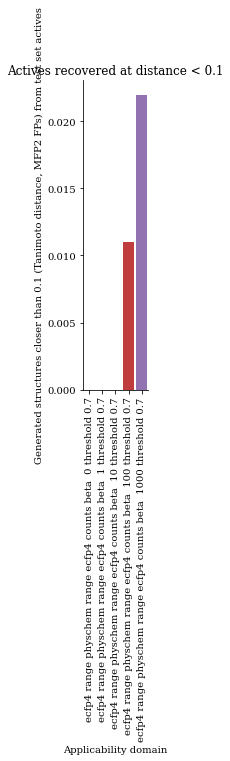

In [132]:
fig = plt.figure(figsize=(25, 25))
novel_01 = []
titles = []

predicted_actives = np.where(clf.predict_proba(ecfp4(smiles_actives))[:, 1]>0.5)[0]

for i, run in enumerate(runs):
    curr_fps_generated = fps_generated_as_bitv[i]
    n_new = 0
    for s in np.array(smiles_actives)[predicted_actives]:
        mol = Chem.MolFromSmiles(s)
        if max_tanimoto_similarity([AllChem.GetMorganFingerprintAsBitVect(mol, 2)], curr_fps_generated)>0.9:
            n_new += 1
    novel_01.append(n_new/len(predicted_actives))
    titles.append(run.replace('_', ' '))
    
display_df = pd.DataFrame(zip(titles, novel_01), columns =['Applicability domain', 'Generated structures closer than 0.1 (Tanimoto distance, MFP2 FPs) from test set actives'])
chart = sns.catplot(x="Applicability domain", y="Generated structures closer than 0.1 (Tanimoto distance, MFP2 FPs) from test set actives", kind="bar", data=display_df)
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.title("Actives recovered at distance < 0.1")
plt.show()

#plt.barh(np.arange(len(novel_01)), novel_01, height = 0.25 , label='fraction of actives recovered at distance < 0.1')
#plt.yticks(ticks = np.arange(len(novel_01)), labels = titles, rotation='horizontal')
#plt.legend(loc=0)
   
#fig.suptitle('Fraction of predicted actives in the dataset at distance < 0.1',fontweight ="bold")

/opt/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 1080x1080 with 0 Axes>

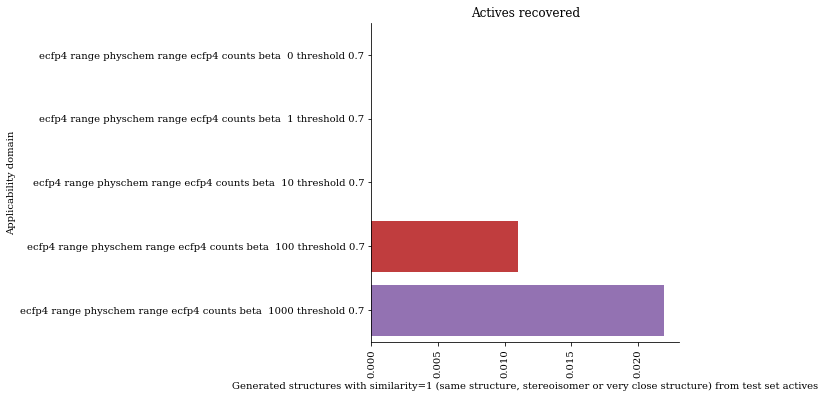

In [133]:
fig = plt.figure(figsize=(15, 15))
novel_recovered = []
titles = []


for i, run in enumerate(runs):
    smiles_generated = smiles_list[i]
    fps_generated = []
    for s in smiles_generated:
        mol = Chem.MolFromSmiles(s)
        fps_generated.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    n_new = 0
    for s in np.array(smiles_actives)[predicted_actives]:
        mol = Chem.MolFromSmiles(s)
        if max_tanimoto_similarity([AllChem.GetMorganFingerprintAsBitVect(mol, 2)], fps_generated)>0.99:
            n_new += 1
    novel_recovered.append(n_new/len(predicted_actives))
    titles.append(run.replace('_', ' '))
display_df = pd.DataFrame(zip(titles, novel_recovered), columns =['Applicability domain', 'Generated structures with similarity=1 (same structure, stereoisomer or very close structure) from test set actives'])
chart = sns.catplot(y="Applicability domain", x="Generated structures with similarity=1 (same structure, stereoisomer or very close structure) from test set actives", kind="bar", data=display_df)
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.title("Actives recovered")
plt.show()

In [134]:
qed_dataset = []
sas_dataset = []
for s in smiles_actives + smiles_inactives:
    mol = Chem.MolFromSmiles(s)
    qed_dataset.append(Descriptors.qed(mol))
    sas_dataset.append(calculateScore(mol))

In [135]:
QED = []
SAS = []

SAS_for_results = []
QED_for_results = []
ad = []
for i, run in enumerate(runs):
    avg_sims = []
    max_sim = []
    smiles_generated = smiles_list[i]
    qed_generated = []
    sas_generated = []
    for s in smiles_generated:
        mol = Chem.MolFromSmiles(s)
        qed_generated.append(Descriptors.qed(mol))
        sas_generated.append(calculateScore(mol))

    
        
        QED.append(Descriptors.qed(mol))
        SAS.append(calculateScore(mol))
        ad.append(run)
    SAS_for_results.append(sas_generated)
    QED_for_results.append(qed_generated)

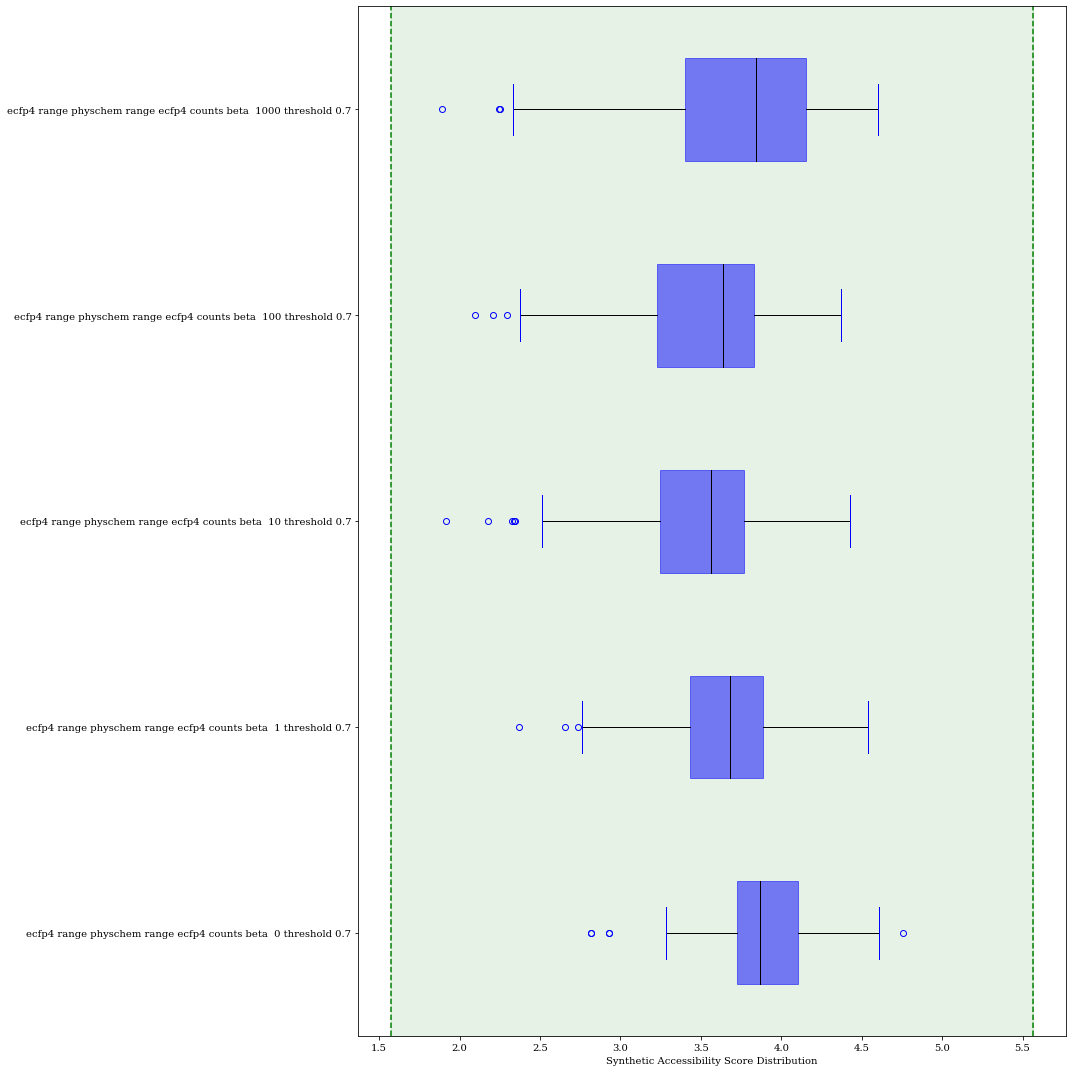

In [136]:

plt.figure(figsize= (15, 15))
#display_df = pd.DataFrame(zip(ad, QED), columns =['Applicability domain', 'QED'])
#chart = sns.boxplot(y="Applicability domain", x="QED", data=display_df)
#['$' + str(x) + '$' for x in runs]
c = 'blue'
box = plt.boxplot(SAS_for_results, labels = [x.replace('_', ' ') for x in runs], vert=False, patch_artist=True,
            boxprops=dict(facecolor=c, color=c, alpha=0.5),
            capprops=dict(color=c),
            whiskerprops=dict(color='k'),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color='k'),)



#plt.boxplot(QED, vert=False)
#plt.yticks(np.arange(len(runs)) + 1, labels=runs, rotation='horizontal')
plt.axvline(np.percentile(sas_dataset, 100), ls='--', label='Dataset extreme QED values', c='g')
plt.axvline(np.percentile(sas_dataset, 0), ls='--', c='g')
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between([np.percentile(sas_dataset, 0), np.percentile(sas_dataset, 100)], ymin, ymax, color='g', alpha=0.1, label = 'Valid QED')
#plt.legend(loc=4)
plt.xlabel("Synthetic Accessibility Score Distribution")
#plt.ylabel("Applicability domain")
plt.xticks()
plt.yticks()


plt.tight_layout()
#plt.savefig('images/JAK2/SAS_distribution.png', dpi=300)

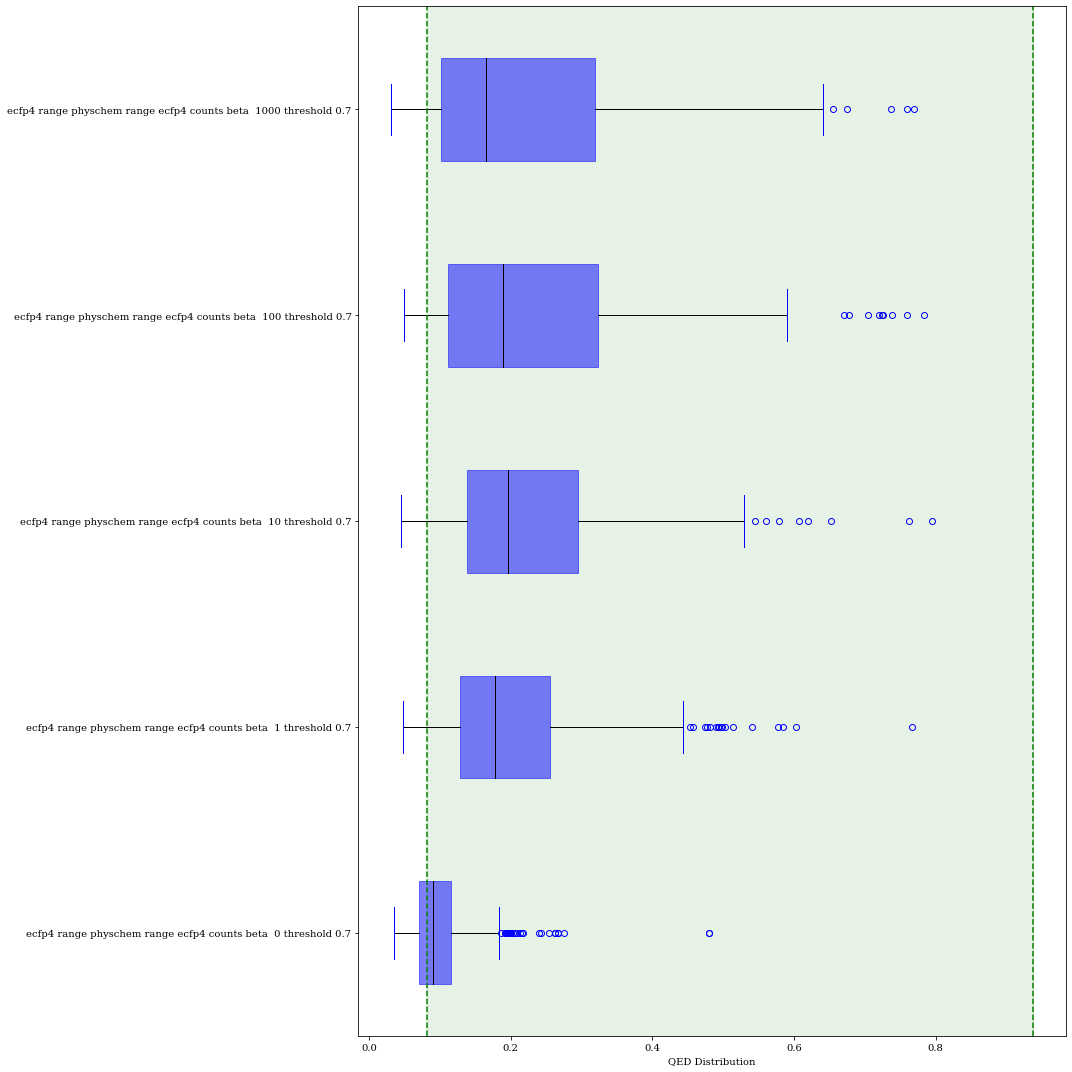

In [137]:
plt.figure(figsize= (15, 15))
#display_df = pd.DataFrame(zip(ad, QED), columns =['Applicability domain', 'QED'])
#chart = sns.boxplot(y="Applicability domain", x="QED", data=display_df)
#['$' + str(x) + '$' for x in runs]
c = 'blue'
box = plt.boxplot(QED_for_results, labels = [x.replace('_', ' ') for x in runs], vert=False, patch_artist=True,
            boxprops=dict(facecolor=c, color=c, alpha=0.5),
            capprops=dict(color=c),
            whiskerprops=dict(color='k'),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color='k'),)



#plt.boxplot(QED, vert=False)
#plt.yticks(np.arange(len(runs)) + 1, labels=runs, rotation='horizontal')
plt.axvline(np.percentile(qed_dataset, 100), ls='--', label='Dataset extreme QED values', c='g')
plt.axvline(np.percentile(qed_dataset, 0), ls='--', c='g')
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between([np.percentile(qed_dataset, 0), np.percentile(qed_dataset, 100)], ymin, ymax, color='g', alpha=0.1, label = 'Valid QED')
#plt.legend(loc=4)
plt.xlabel("QED Distribution")
#plt.ylabel("Applicability domain")
plt.xticks()
plt.yticks()


plt.tight_layout()
#plt.savefig('images/JAK2/QED_distribution.png', dpi=300)

# Comparing different AD's outputs

In [138]:
from utils import qualitative_analysis, return_distribution_cycle_size, return_distribution_mw, return_distribution_halogen, return_distribution_heteroatoms, return_distribution_radicals, return_distribution_sulphur, qualitative_analysis

In [139]:
average_similarities = []
max_similarities = []
common_molecules = {}
for i, run in enumerate(runs):
    avg_sims = []
    max_sim = []
    smiles_generated = smiles_list[i]
    fps_generated = fps_generated_as_bitv[i]
    for j, comparison_run in enumerate(runs):
        smiles_generated = smiles_list[j]
        fps_other = fps_generated_as_bitv[j]
        if j<i:
            indexes, indexes_other = indexes_identical_fps(fps_generated, fps_other)
            common_molecules[run + '_vs_' + comparison_run] = [indexes, indexes_other] 
        avg_sims.append(average_tanimoto_similarity(fps_generated, fps_other))
        max_sim.append(max_tanimoto_similarity(fps_generated, fps_other))
    average_similarities.append(avg_sims)
    max_similarities.append(max_sim)

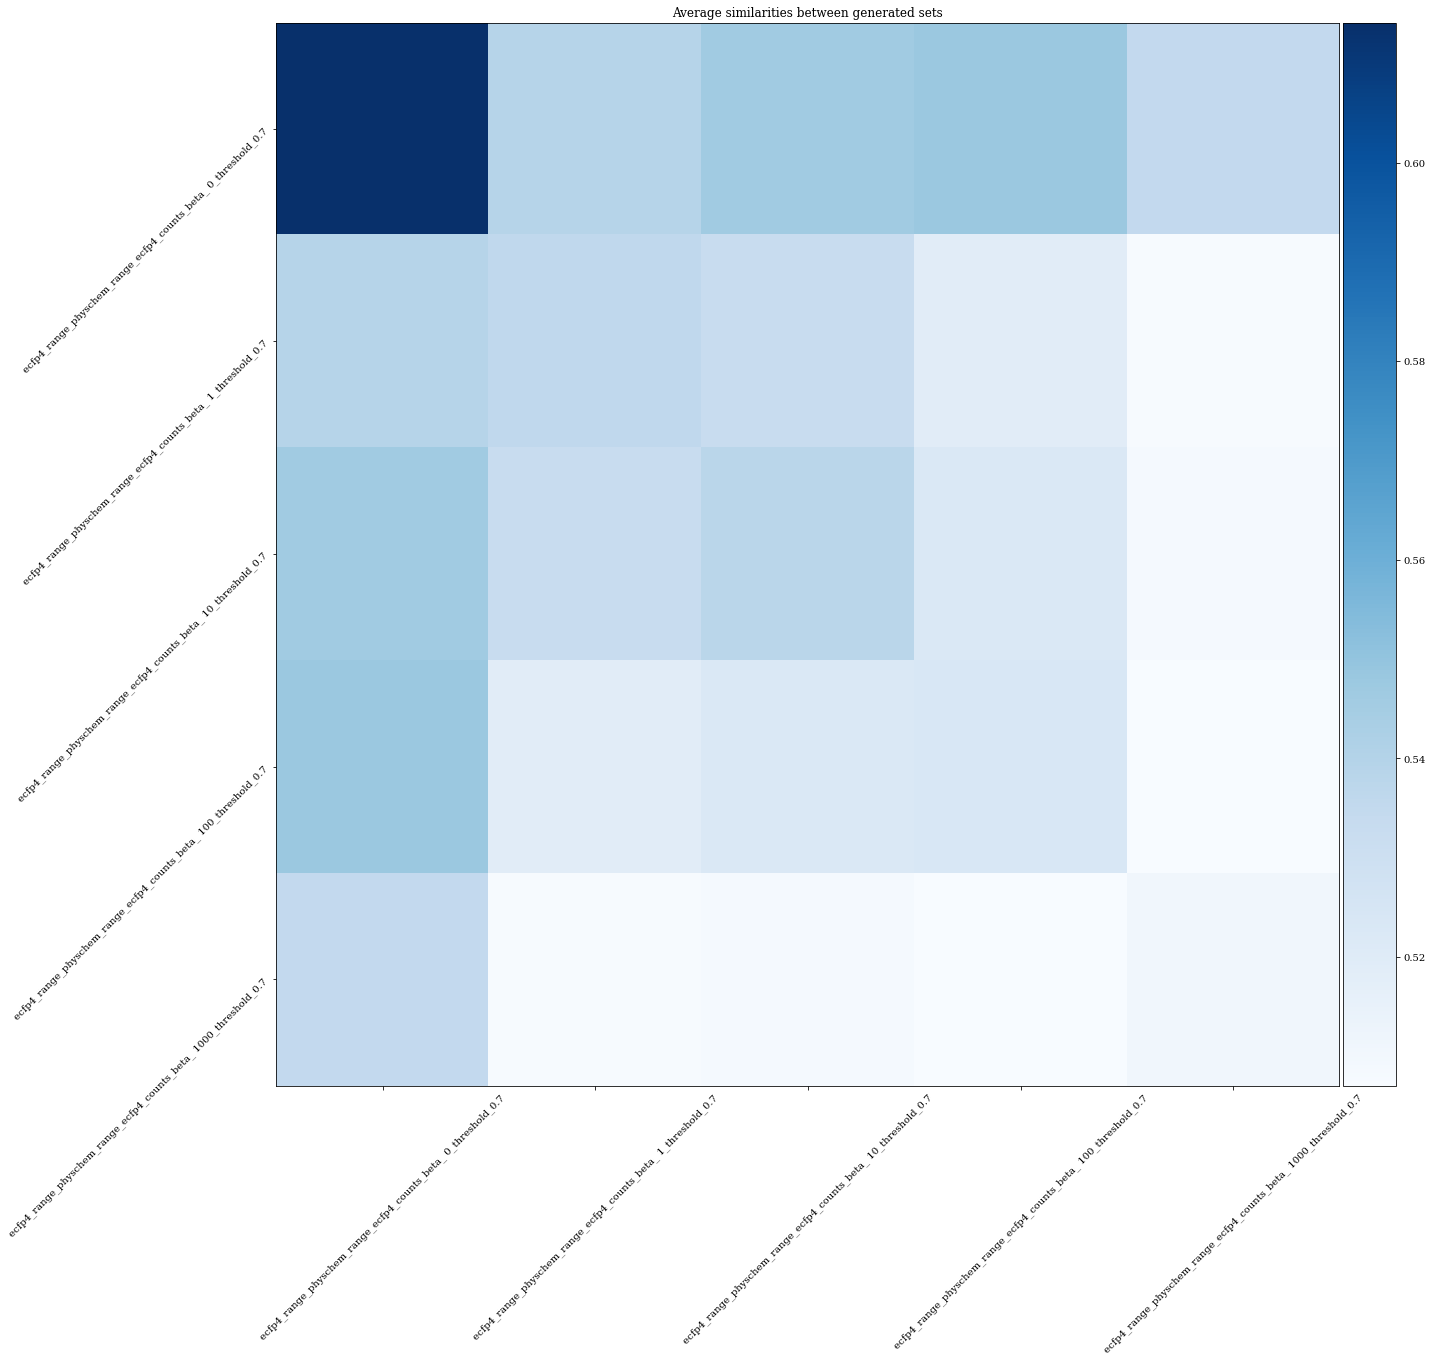

In [140]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

labels = runs

fig, ax = plt.subplots(figsize = (20, 20), nrows=1 , ncols=1)

fig.tight_layout(pad=1.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)



ax.set_title("Average similarities between generated sets")

im = ax.imshow(np.array(average_similarities), cmap='Blues')
ax.set_yticks(ticks=range(len(runs)))
ax.set_xticks(ticks=range(len(runs)))
ax.set_xticklabels(labels, rotation=45)
ax.set_yticklabels(labels, rotation=45)
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
#plt.colorbar()
fig.tight_layout(pad=3.0)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.grid(False)

plt.tight_layout()
#plt.savefig('images/JAK2/similarities.png', dpi=300)

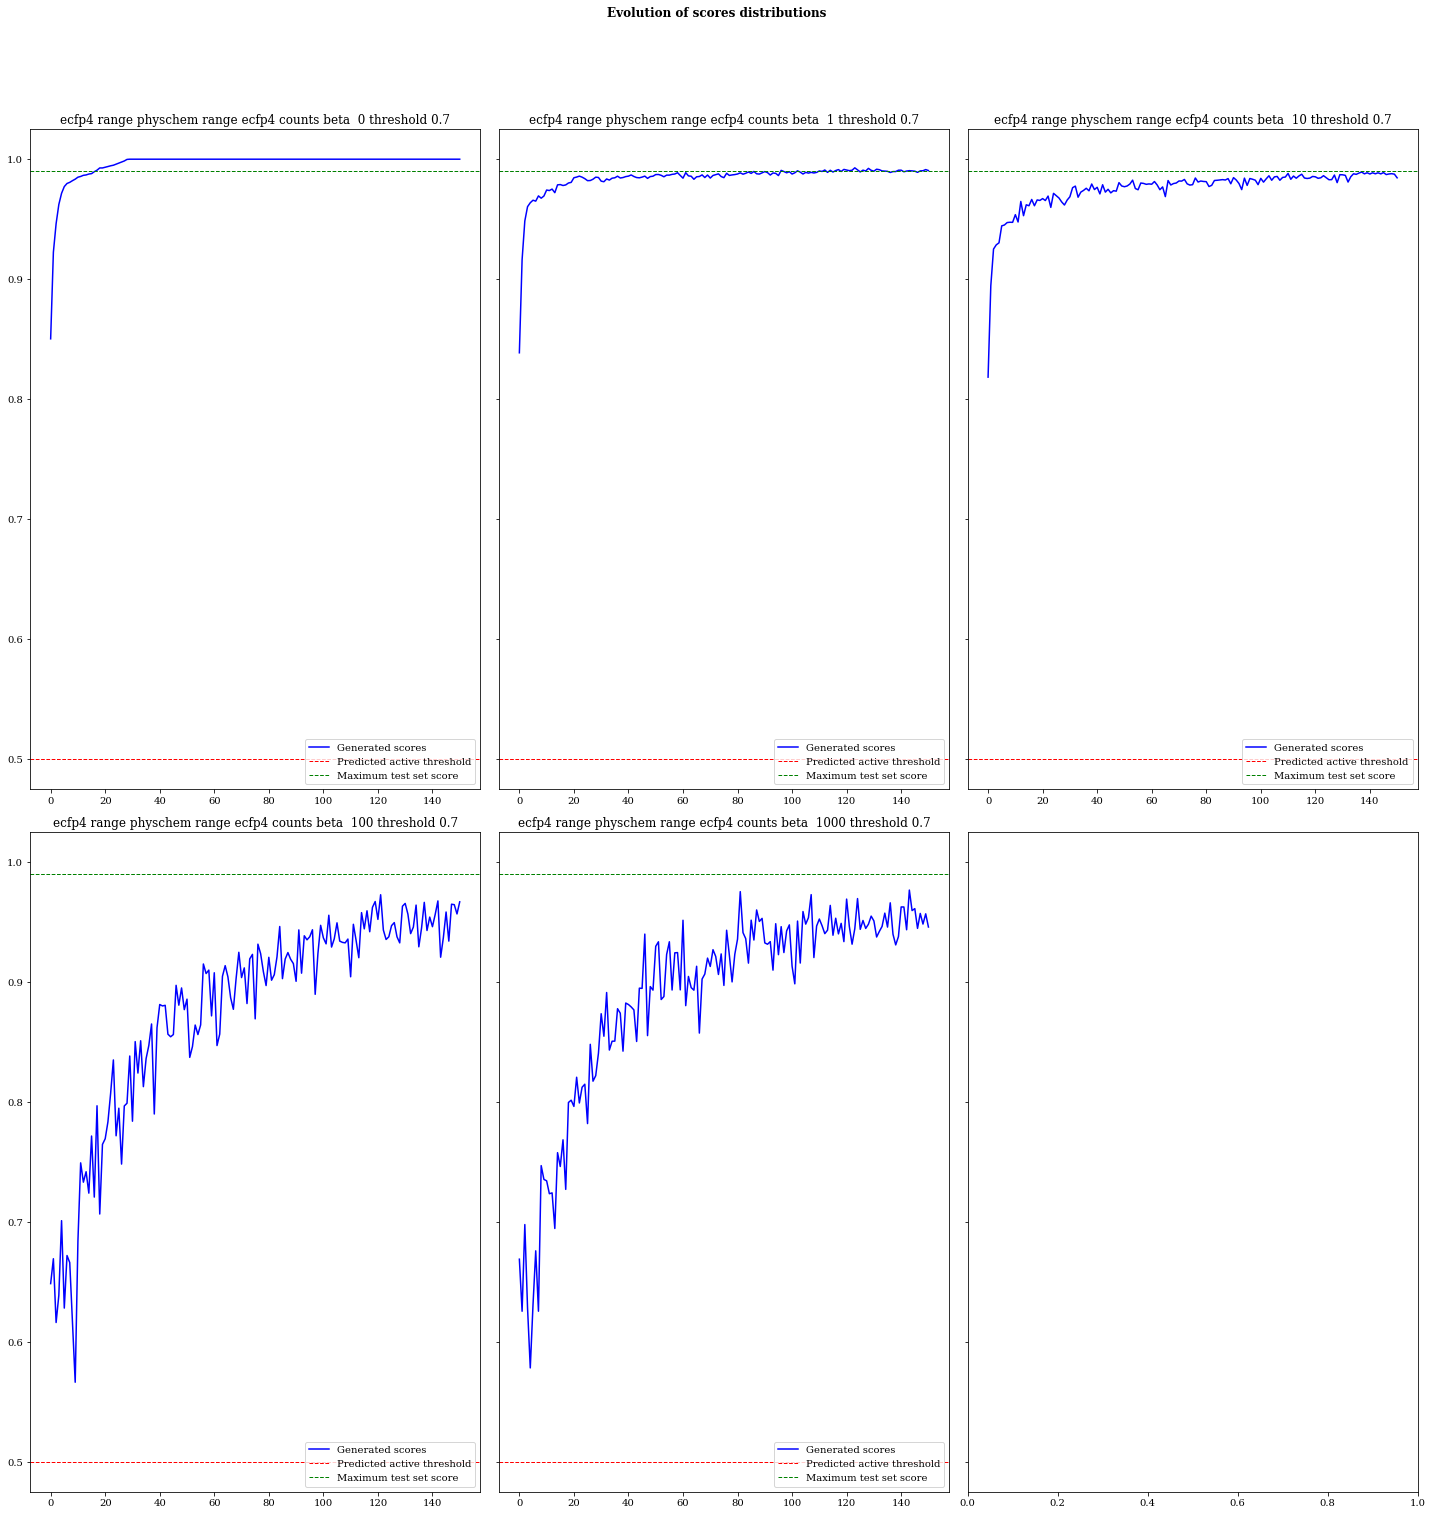

In [141]:
fig, axs = plt.subplots(figsize = (20, 20), nrows=max(1, math.ceil(len(runs)/3)) , ncols=3, sharey=True)

fig.tight_layout(pad=1.5)

for i, run in enumerate(runs):
    ax = axs.flatten()[i]
    ax.set_title(run.replace('_', ' '))
    scores = np.array(scores_trajectories[runs.index(run)])
    """
    median = np.median(scores, 1)
    q25 = np.percentile(scores, 5, axis=1)
    q75 = np.percentile(scores, 95, axis=1)
    ax.plot(median, c='b', label='Generated scores')
    ax.fill_between(
        np.arange(median.shape[0]), q25, q75, alpha=.1, color='b')
    """
    ax.plot(scores, c='b', label='Generated scores')
    ax.axhline(y=0.5, linewidth=1, ls='--', color='r', label='Predicted active threshold')
    ax.axhline(y=np.max(scores_test), linewidth=1, ls='--', color='g', label='Maximum test set score')
    ax.legend(loc=4)
fig.suptitle('Evolution of scores distributions', fontweight ="bold", y=1.05)
plt.tight_layout()

# Additional functions

In [150]:
import random 
optimisation_scores = []
joint_scores = []
logp_scores = []
cvars = []
at_least_one = []

current_joint_scores = []
current_logp_scores = []
current_cvars = []
current_at_least_one = []

beta_list = []
lcorr_list = []
n_smiles_list = []

for seed in range(50):
    print(seed)
    np.random.seed(seed)
    """
    length = np.random.uniform(1, 2)
    
    threshold_low_clogp_random = np.random.uniform(0, 5)
    threshold_low_clogp = random.choice([threshold_low_clogp_random, 7])
    threshold_low_clogp = random.choice(logp_test) -length/2
    threshold_high_clogp = threshold_low_clogp + length/2
    

    length = np.random.uniform(10, 15)
    threshold_low_tpsa_random = np.random.uniform(70, 130)
    threshold_low_tpsa = threshold_low_tpsa_random
    #threshold_low_tpsa = random.choice([threshold_low_tpsa_random, threshold_low_tpsa_random, 140])
    #threshold_low_tpsa = np.random.uniform(70, 130)
    threshold_high_tpsa = threshold_low_tpsa + length
    """
    cluster = random.choice(range(5))
    mw_threshold = random.choice([550, 650])
    criteria = "clogp"
    
    """
    smiles_valid = np.random.choice(smiles_test, 100)
    fp_valid = []
    for s in smiles_valid:
        fp_valid.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    """
    """
    #smiles_generated = np.random.choice(smiles_augmented, 3000)
    ground_truth = []
    smiles_generated = smiles_list[j]
    for s in smiles_generated:
        mol = Chem.MolFromSmiles(s)
        fp = ecfp4([s])[0].reshape(1, -1)
        prediction = clf.predict_proba(fp)[0, 1]
        #prediction = np.random.binomial(prediction, 1)
        ground_truth.append(prediction)
    """    
    for j, directory in enumerate(runs):
        smiles_generated = smiles_list[j]
        scores_generated = scores_list[j]
        for lcorr in [0.5]:
            for n_smiles in [1, 10, 100]:
                for seed_other in range(10):
                    np.random.seed(seed_other)

                    betas = [0, 1, 10, 100, 1000]
                    beta = round(betas[j], 2)
                    lcorr = round(lcorr, 2)

                    solutions_risk_adverse = random.sample(smiles_generated, n_smiles)
                    current_optimisation_score = []
                    
                    n_smiles_list.append(n_smiles)
                    beta_list.append(beta)
                    lcorr_list.append(lcorr)


                    scores = [] 
                    scores_additional = []
                    scores_prediction = []
                    for s in solutions_risk_adverse:
                        mol = Chem.MolFromSmiles(s)
                        fp = ecfp4([s])[0].reshape(1, -1)
                        prediction = clf.predict_proba(fp)[0, 1]
                        prediction = np.random.binomial(1, prediction)
                        fp = np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)).reshape(1, -1)
                        additional = 1 * clustering.predict(fp)[0]==cluster
                        scores_additional.append(additional)
                        scores.append(additional*prediction) 
                        
                        scores_prediction.append(prediction)
                    if np.sum(scores)==0:
                        at_least_one.append(0)
                    else:
                        at_least_one.append(1)
                    optimisation_scores.append(np.mean(scores_prediction))
                    logp_scores.append(np.mean(scores_additional))
                    joint_scores.append(np.mean(scores))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


<AxesSubplot:title={'center':'At least one molecule according to selection parameters'}, xlabel='Beta', ylabel='N'>

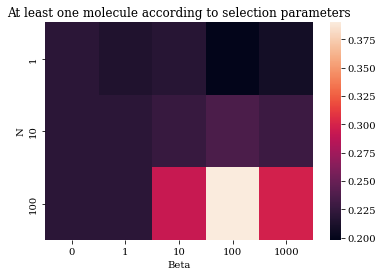

In [151]:
display_df = pd.DataFrame(zip(joint_scores, logp_scores, optimisation_scores,  at_least_one, lcorr_list, beta_list, n_smiles_list), columns =['Average score', 'Additional score', 'Optimization score', 'At least one', "Length of correlation", 'Beta', 'N'])
plt.title("At least one molecule according to selection parameters")
pivoted = display_df.groupby(["Beta", "N"]).mean().reset_index().pivot("N", "Beta", "At least one")
sns.heatmap(pivoted)

In [152]:
logps = []

for l in smiles_list:
    current_logp = []
    for s in l:
        fp = ecfp4([s])[0].reshape(1, -1)
        current_logp.append(MolLogP(Chem.MolFromSmiles(s)))
    logps.append(current_logp)
    
logp_test = []
for s in np.array(smiles_actives + smiles_inactives):
    fp = ecfp4([s])[0].reshape(1, -1)
    logp_test.append(MolLogP(Chem.MolFromSmiles(s)))

In [156]:
tpsa_test = []
for s in np.array(smiles_actives + smiles_inactives):
    tpsa_test.append(CalcTPSA(Chem.MolFromSmiles(s)))

In [153]:
def is_valid(smiles, criteria="mw", threshold_low_clogp=0, threshold_high_clogp=2, threshold_low_tpsa=50, threshold_high_tpsa=70, mw_threshold=350):
    mol = Chem.MolFromSmiles(s)
    logp = MolLogP(mol)>=threshold_low_clogp and MolLogP(mol)<=threshold_high_clogp
    tpsa = CalcTPSA(mol)>=threshold_low_tpsa and CalcTPSA(mol)<=threshold_high_tpsa
    mw = ExactMolWt(mol)<mw_threshold
    #return logp * tpsa
    if criteria=="mw":
        return mw
    elif criteria== "clogp":
        return logp
    else:
        return tpsa

In [154]:
import random 
optimisation_scores = []
joint_scores = []
logp_scores = []
cvars = []
at_least_one = []

current_joint_scores = []
current_logp_scores = []
current_cvars = []
current_at_least_one = []

beta_list = []
lcorr_list = []
n_smiles_list = []

for seed in range(50):
    print(seed)
    np.random.seed(seed)
    
    length = np.random.uniform(1, 2)
    
    threshold_low_clogp_random = np.random.uniform(0, 5)
    threshold_low_clogp = random.choice([threshold_low_clogp_random, 7])
    threshold_low_clogp = random.choice(logp_test) -length/2
    threshold_high_clogp = threshold_low_clogp + length/2
    

    length = np.random.uniform(10, 15)
    threshold_low_tpsa_random = np.random.uniform(70, 130)
    threshold_low_tpsa = threshold_low_tpsa_random
    #threshold_low_tpsa = random.choice([threshold_low_tpsa_random, threshold_low_tpsa_random, 140])
    #threshold_low_tpsa = np.random.uniform(70, 130)
    threshold_high_tpsa = threshold_low_tpsa + length
    
    cluster = random.choice(range(5))
    mw_threshold = random.choice([550, 650])
    criteria = "clogp"
    
    for j, directory in enumerate(runs):
        smiles_generated = smiles_list[j]
        scores_generated = scores_list[j]
        for lcorr in [0.5]:
            for n_smiles in [1, 10, 100]:
                for seed_other in range(10):
                    np.random.seed(seed_other)

                    betas = [0, 1, 10, 100, 1000]
                    beta = round(betas[j], 2)
                    lcorr = round(lcorr, 2)

                    solutions_risk_adverse = random.sample(smiles_generated, n_smiles)
                    current_optimisation_score = []
                    
                    n_smiles_list.append(n_smiles)
                    beta_list.append(beta)
                    lcorr_list.append(lcorr)


                    scores = [] 
                    scores_additional = []
                    scores_prediction = []
                    for s in solutions_risk_adverse:
                        mol = Chem.MolFromSmiles(s)
                        fp = ecfp4([s])[0].reshape(1, -1)
                        prediction = clf.predict_proba(fp)[0, 1]
                        prediction = np.random.binomial(1, prediction)
                        fp = np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)).reshape(1, -1)
      
                        scores_additional.append(is_valid(s, "clogp", threshold_low_clogp, threshold_high_clogp, threshold_low_tpsa, threshold_high_tpsa, mw_threshold))
                        scores.append(is_valid(s, "clogp", threshold_low_clogp, threshold_high_clogp, threshold_low_tpsa, threshold_high_tpsa, mw_threshold)*prediction) 
     
                        scores_prediction.append(prediction)
                    if np.sum(scores)==0:
                        at_least_one.append(0)
                    else:
                        at_least_one.append(1)
                    optimisation_scores.append(np.mean(scores_prediction))
                    logp_scores.append(np.mean(scores_additional))
                    joint_scores.append(np.mean(scores))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


<AxesSubplot:title={'center':'At least one molecule according to selection parameters'}, xlabel='Beta', ylabel='N'>

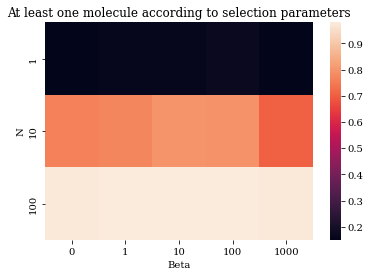

In [155]:
display_df = pd.DataFrame(zip(joint_scores, logp_scores, optimisation_scores,  at_least_one, lcorr_list, beta_list, n_smiles_list), columns =['Average score', 'Additional score', 'Optimization score', 'At least one', "Length of correlation", 'Beta', 'N'])
plt.title("At least one molecule according to selection parameters")
pivoted = display_df.groupby(["Beta", "N"]).mean().reset_index().pivot("N", "Beta", "At least one")
sns.heatmap(pivoted)

In [158]:
optimisation_scores = []
joint_scores = []
logp_scores = []
cvars = []
at_least_one = []

current_joint_scores = []
current_logp_scores = []
current_cvars = []
current_at_least_one = []

beta_list = []
lcorr_list = []
n_smiles_list = []

for seed in range(50):
    print(seed)
    np.random.seed(seed)
    
    length = np.random.uniform(1, 2)
    
    threshold_low_clogp_random = np.random.uniform(0, 5)
    threshold_low_clogp = random.choice([threshold_low_clogp_random, 7])
    threshold_low_clogp = random.choice(logp_test) -length/2
    threshold_high_clogp = threshold_low_clogp + length/2
    

    length = np.random.uniform(10, 15)
    threshold_low_tpsa_random = np.random.uniform(70, 130)
    threshold_low_tpsa = random.choice(tpsa_test) - length/2
    threshold_high_tpsa = threshold_low_clogp + length/2
    
    cluster = random.choice(range(5))
    mw_threshold = random.choice([550, 650])
    criteria = "clogp"

    for j, directory in enumerate(runs):
        smiles_generated = smiles_list[j]
        scores_generated = scores_list[j]
        for lcorr in [0.5]:
            for n_smiles in [1, 10, 100]:
                for seed_other in range(10):
                    np.random.seed(seed_other)

                    betas = [0, 1, 10, 100, 1000]
                    beta = round(betas[j], 2)
                    lcorr = round(lcorr, 2)

                    solutions_risk_adverse = random.sample(smiles_generated, n_smiles)
                    current_optimisation_score = []
                    
                    n_smiles_list.append(n_smiles)
                    beta_list.append(beta)
                    lcorr_list.append(lcorr)


                    scores = [] 
                    scores_additional = []
                    scores_prediction = []
                    for s in solutions_risk_adverse:
                        mol = Chem.MolFromSmiles(s)
                        fp = ecfp4([s])[0].reshape(1, -1)
                        prediction = clf.predict_proba(fp)[0, 1]
                        prediction = np.random.binomial(1, prediction)
                        fp = np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)).reshape(1, -1)
             
                        scores_additional.append(is_valid(s, "tpsa", threshold_low_clogp, threshold_high_clogp, threshold_low_tpsa, threshold_high_tpsa, mw_threshold))
                        scores.append(is_valid(s, "tpsa", threshold_low_clogp, threshold_high_clogp, threshold_low_tpsa, threshold_high_tpsa, mw_threshold)*prediction) 
                
                        
                        scores_prediction.append(prediction)
                    if np.sum(scores)==0:
                        at_least_one.append(0)
                    else:
                        at_least_one.append(1)
                    optimisation_scores.append(np.mean(scores_prediction))
                    logp_scores.append(np.mean(scores_additional))
                    joint_scores.append(np.mean(scores))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


<AxesSubplot:title={'center':'At least one molecule according to selection parameters'}, xlabel='Beta', ylabel='N'>

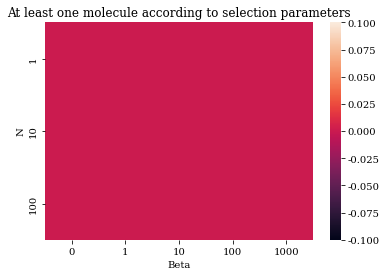

In [160]:
display_df = pd.DataFrame(zip(joint_scores, logp_scores, optimisation_scores,  at_least_one, lcorr_list, beta_list, n_smiles_list), columns =['Average score', 'Additional score', 'Optimization score', 'At least one', "Length of correlation", 'Beta', 'N'])
plt.title("At least one molecule according to selection parameters")
pivoted = display_df.groupby(["Beta", "N"]).mean().reset_index().pivot("N", "Beta", "At least one")
sns.heatmap(pivoted)